# Bikes

In [1]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
bikes = pd.read_csv("bikes.csv")
bikes["hour_sin"] = np.sin(bikes.hour * np.pi / 12)
bikes["hour_cos"] = np.cos(bikes.hour * np.pi / 12)

data = bikes[["count", "hour_sin", "hour_cos", "temperature", "humidity", "windspeed"]]


We define a linear model using Bambi's syntax, where "hour" is the response variables and "hour", "temperature", "humidity" and "windspeed" are the covariates

In [6]:
model = bmb.Model("count ~ hour_sin + hour_cos + temperature + humidity + windspeed", data=data)

By default Bambi use a Gaussian likelihood with normal priors for the coeeficients in the linear term and a Half-Student t for sigma 

In [7]:
model

Formula: count ~ hour_sin + hour_cos + temperature + humidity + windspeed
Family name: Gaussian
Link: identity
Observations: 348
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 192.227, sigma: 2106.8107)
    hour_sin ~ Normal(mu: 0.0, sigma: 648.8377)
    hour_cos ~ Normal(mu: 0.0, sigma: 648.0963)
    temperature ~ Normal(mu: 0.0, sigma: 2363.053)
    humidity ~ Normal(mu: 0.0, sigma: 2428.6856)
    windspeed ~ Normal(mu: 0.0, sigma: 3961.1844)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 183.4114)

We fit the model. This is calling `pm.sample()` under the hood.

In [8]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, hour_sin, hour_cos, temperature, humidity, windspeed, count_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Now we use Kulrprit to perform variable selection via projective prediction. In a nutshell we use the fitted model as the reference model, and we look to identify subsets of its parameters that achieve similar predictive performance.

In [9]:
ref_model = kpt.ReferenceModel(model, idata)
ref_model.search()

Starting from the intercept-only model up to all covariables, which variables we should include to get better and better predictions?

In [10]:
for value in ref_model.path.values(): 
    print(value.model.formula)

count ~ 1
count ~ hour_cos
count ~ hour_cos + hour_sin
count ~ hour_cos + hour_sin + temperature
count ~ hour_cos + hour_sin + temperature + windspeed
count ~ hour_sin + hour_cos + temperature + humidity + windspeed


We can also evaluate the submodels in terms of LOO

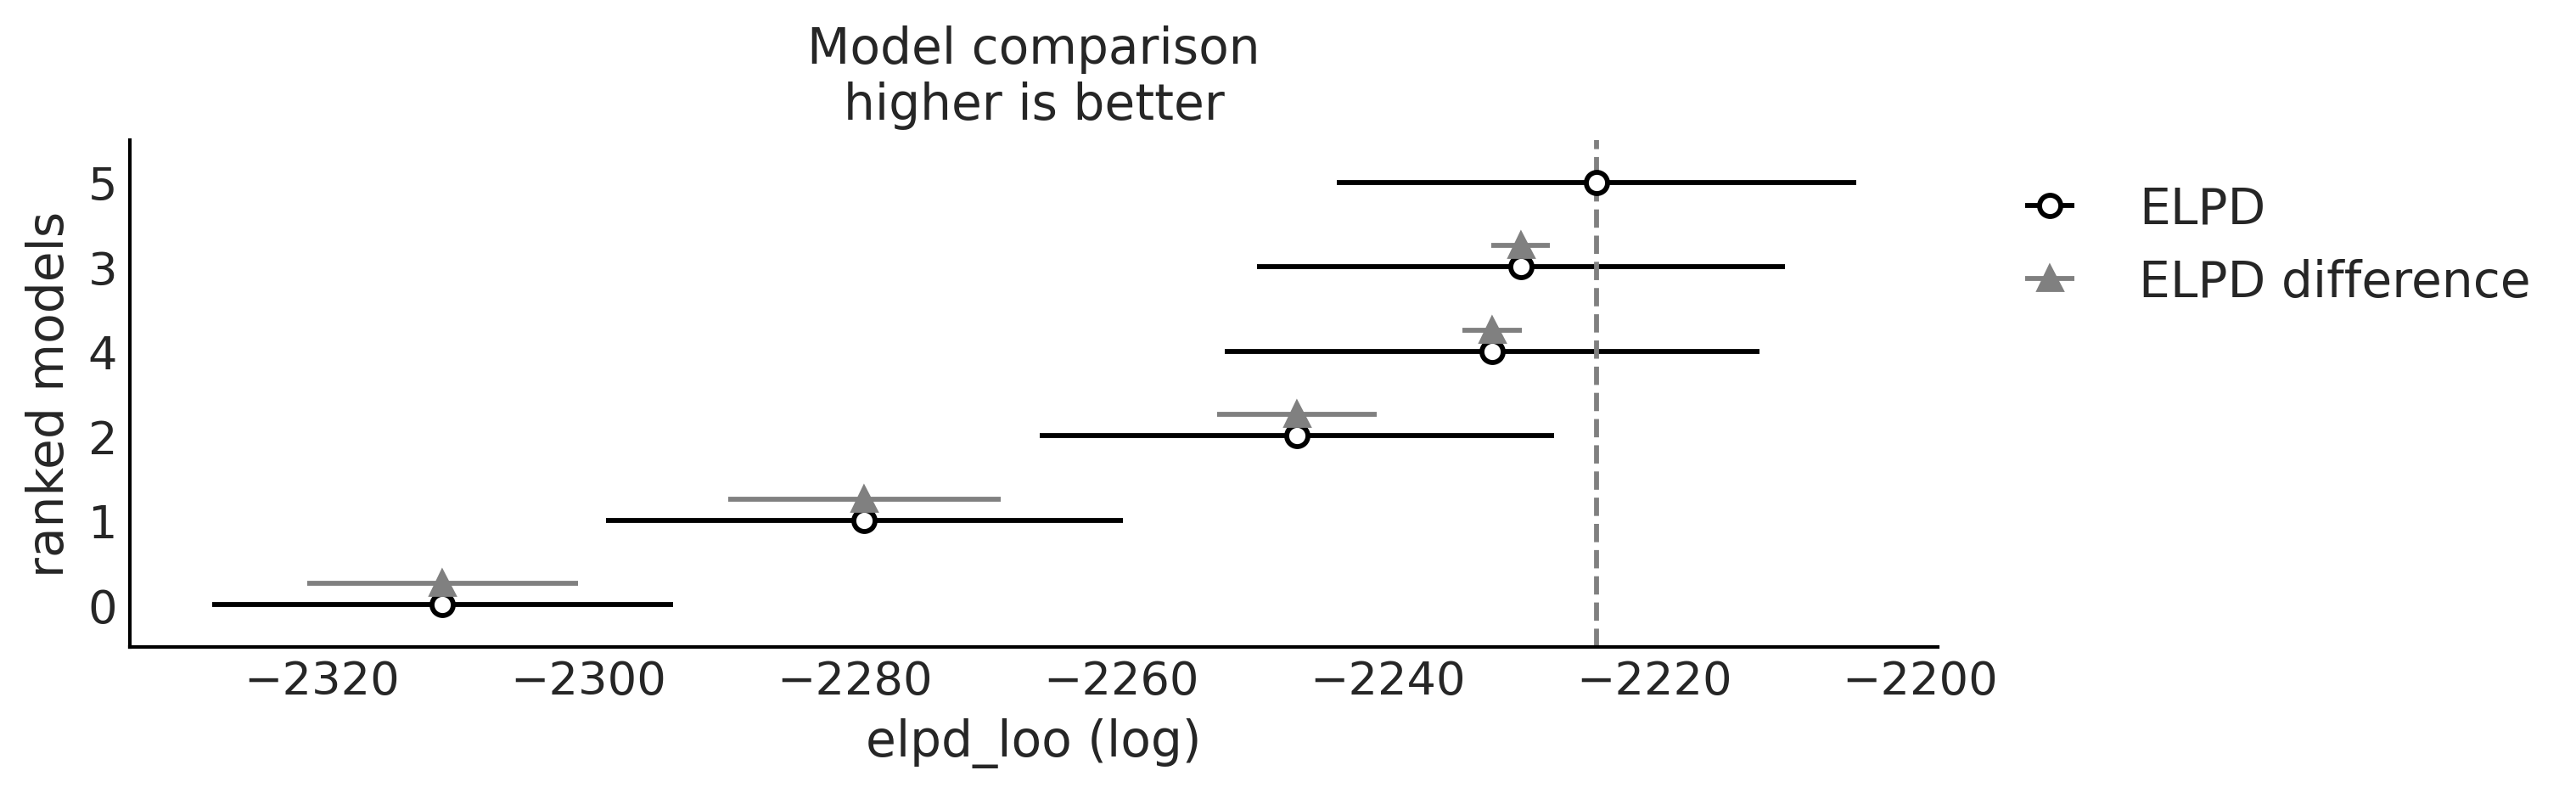

In [11]:
cmp, ax = ref_model.loo_compare(plot=True, plot_kwargs={"figsize":(10, 3)});